## Setup

In [24]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

FIG_PATH = "./figs/"

## Load data

In [2]:
def parse_date(date: str):
    '''
    returns formatted date
    Example: date: 15th May 2009
             return: May 15
    '''
    day, month, year = date.split(" ")
    day = day[:-2]
    return f"{month} {day}"


def load_data(xlsx_file="../data/H1N1.xlsx"):
    data = pd.read_excel(xlsx_file)
    parsed_dates = [parse_date(date) for date in data["Date"]]
    data["Formatted date"] = parsed_dates
    return data

data = load_data()
data

,Date,Number of cases,Formatted date
0,27th April 2009,1,April 27
1,28th April 2009,1,April 28
2,29th April 2009,0,April 29
3,30th April 2009,2,April 30
4,1st May 2009,5,May 1
5,2nd May 2009,3,May 2
6,3rd May 2009,3,May 3
7,4th May 2009,3,May 4
8,5th May 2009,6,May 5
9,6th May 2009,2,May 6


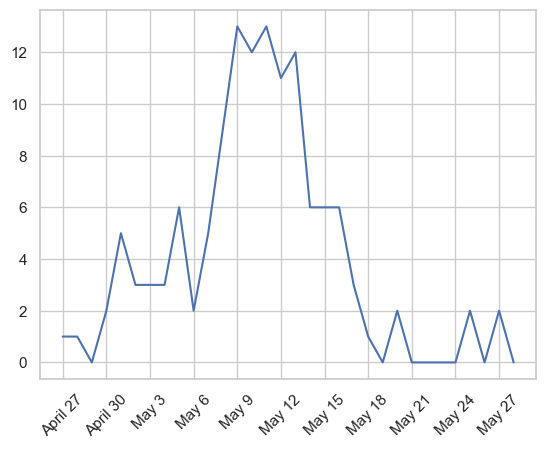

In [3]:
C = data["Number of cases"]
plt.plot(C)
ticks = np.arange(0, len(C), 3)
labels = [data["Formatted date"][i] for i in ticks]
plt.xticks(ticks=ticks, labels=labels, rotation=45)
plt.show()

In [4]:
si = [2.24, 2.85, 9.31, 49.83, 64.49, 49.07, 23.76, 7.07, 1.51]
scale = (1.37 / 10.92 * 0.05 + 0.3) / 64.49
beta = scale * np.array(si)
np.sum(beta)

0.9979395746394506

In [5]:
from scipy.stats import gamma

class H1N1:
    def __init__(
        self,
        shape=16,     # shape of the incubation period distribution (gamma)
        scale=0.125,  # scale of the incubation period distribution (gamma)
        tau=6,       # truncation bound of the incubation period distribution
        xlsx_file="../data/H1N1.xlsx" #xlsx file of the daily cases
    ):
        self.shape = shape
        self.scale = scale
        self.tau = tau
        self.xlsx_file = xlsx_file
        self.dates = np.array([])
        self.C = np.array([])
        self.I = np.array([])
        self.data = pd.DataFrame()
        self.data_seg = np.array([])

    def _parse_date(self, date):
        '''
        returns formatted date
        Example: date: 15th May 2009
                return: May 15
        '''
        day, month, year = date.split(" ")
        day = day[:-2]
        return f"{month} {day}"

    def _compute_serial_interval(self):
        si = [2.24, 2.85, 9.31, 49.83, 64.49, 49.07, 23.76, 7.07, 1.51]
        scale = (1.37 / 10.92 * 0.05 + 0.3) / 64.49
        self.beta = scale * np.array(si)
        # no return
        
    def _compute_time_delay(self):
        N = self.C.shape[0]
        H = np.zeros((N, N))
        psf = [gamma.pdf(i+1, a=self.shape, scale=self.scale) for i in range(self.tau)]
        psf = 1 / np.sum(psf) * np.array(psf)
        for i in range(N):
            if i+self.tau > N:
                temp = N
            else:
                temp = i+self.tau
            for j in range(i, temp):
                H[i, j] = psf[j-i]
        self.H = H
        # no return
    
    def load_data(self, n_padding=5):
        '''
        load data from outbreak
        n_padding: number of days of padding on the left with zero 
        '''
        data = pd.read_excel(self.xlsx_file)
        parsed_dates = [self._parse_date(date) for date in data["Date"]]
        data["Formatted date"] = parsed_dates

        day = int(parsed_dates[0].split(" ")[-1])
        if n_padding > day:
            raise ValueError(f"n_padding too large. Please keep the date in April by setting n_padding less than {day}")

        padding_dates = [f"April {day-i}" for i in range(n_padding, 0, -1)]

        self.C = np.concatenate([np.zeros((n_padding,)), data["Number of cases"]])
        self.dates = np.concatenate([padding_dates, parsed_dates])

        self._compute_serial_interval()
        self._compute_time_delay()

        # reconstruction of incidence sequence
        self.I = np.dot(self.H, self.C).astype(int)

        # prepare date segments for low-level model parameters estimation 
        n = len(self.beta)
        data_seg = np.empty((len(self.I)-n+1, n))
        for i in range(data_seg.shape[0]):
            data_seg[i, :] = self.I[i:i+n][::-1]
        self.dates = self.dates[n-1:]
        self.I = self.I[n-1:]
        self.C = self.C[n-1:]
        self.data_seg = data_seg




In [6]:
h1n1 = H1N1()
h1n1.load_data()

In [7]:
from utils.model import myStudy

hp_file = "./logs/BestHyperParams-2022-11-19-21-39-28.json"
with open(hp_file) as f: 
    hpDict = json.load(f)
    f.close()
S = myStudy(data_seg=h1n1.data_seg, hpDict=hpDict, silent=False)
res = S.estimate_params()

+ Created new study.
+ Successfully imported array.
+ Observation model: likelihood. Parameter(s): ('R', 'D')
+ Transition model: Serial transition model. Hyper-Parameter(s): ['s1R', 's1D', 's2R', 's2D', 's3R', 's3D', 't1', 't2']
+ Started new fit:
    + Formatted data.
    + Set uniform prior with parameter boundaries.


  0%|          | 0/29 [00:00<?, ?it/s]

    + Finished forward pass.
    + Log10-evidence: -28.47422


  0%|          | 0/29 [00:00<?, ?it/s]

    + Finished backward pass.
    + Computed mean parameter values.


In [8]:
print(f"First structural break point: {h1n1.dates[hpDict['t1']]}")
print(f"Second structural break point: {h1n1.dates[hpDict['t2']]}")

First structural break point: May 6
Second structural break point: May 13


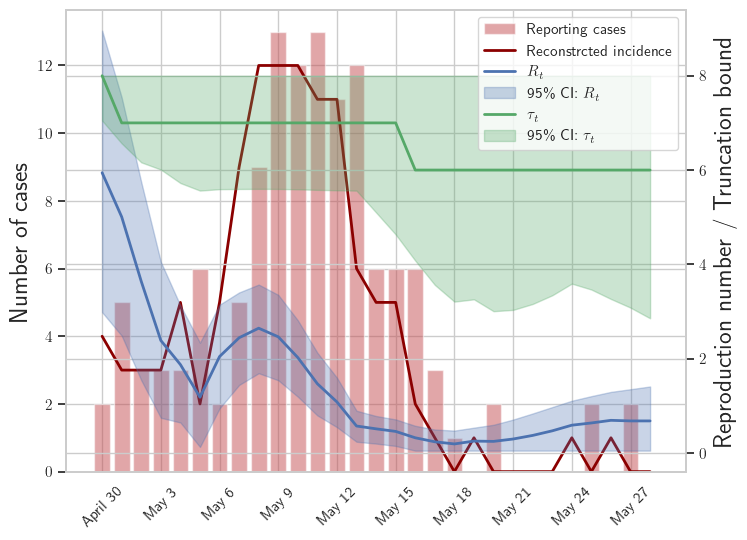

In [30]:
f, ax1 = plt.subplots(1, 1, figsize=(8, 6))
plt.rcParams['text.usetex'] = True
lw = 2

barC = ax1.bar(S.rawTimestamps, h1n1.C, align='center', facecolor='r', alpha=.5)
curveI, = ax1.plot(S.rawTimestamps, h1n1.I, c='darkred', linewidth=lw)
ax1.set_ylabel(r"Number of cases", fontsize=18)

ax2 = ax1.twinx()
ax2.set_ylabel(r"Reproduction number / Truncation bound", fontsize=18)
curveR, = ax2.plot(S.rawTimestamps, S.getParameterMeanValues("R"), 'b', linewidth=lw)
R_lowers, R_uppers = res["R"]["lowers"], res["R"]["uppers"]
contourR = ax2.fill_between(S.rawTimestamps, R_lowers, R_uppers, alpha=0.3, color="b")

Ds = [int(D) for D in S.getParameterMeanValues("D")]
curveD, = ax2.plot(S.rawTimestamps, Ds, 'g', linewidth=lw)
D_lowers, D_uppers = res["D"]["lowers"], res["D"]["uppers"]
contourD = ax2.fill_between(S.rawTimestamps, D_lowers, D_uppers, alpha=0.3, color="g")

ticks = np.arange(0, len(h1n1.C), 3)
labels = [h1n1.dates[i] for i in ticks]
ax1.set_xticks(ticks=ticks, labels=labels, rotation=45)

plt.legend(
    [barC, curveI, curveR, contourR, curveD, contourD, ],
    ["Reporting cases", "Reconstrcted incidence", "$R_t$", 
    "95\% CI: $R_t$", r"$\tau_t$", r"95\% CI: $\tau_t$"],
     loc="upper right",

)

plt.savefig(os.path.join(FIG_PATH, "H1N1.svg"), bbox_inches="tight")
plt.show()